## DiffPrivLib

Library that provides implementations of DP mechanisms and models based on `numpy` and `sklearn`. For DP implementations of iterative models, the library uses [joblib](https://joblib.readthedocs.io/en/latest/parallel.html). They specifically use the vector mechanism to perturb convex objective functions.

This notebook explores a specific use case, comparing private and non-private logistic regression to predict the ourcome of a police stop using data from the state of Vermont.

In [1]:
# import libraries
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from diffprivlib.mechanisms import Laplace
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as LogisticRegressiondp
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import json

In [3]:
with open('../data/codes_to_cat.txt', 'r') as f:
    xwalk = json.load(f)

In [5]:
# load dataset and specify predictors/target
df = pd.read_csv('../data/alldata.csv', index_col='Unnamed: 0')
predictors = df.drop(['stop_outcome'], axis = 1)
target = df.stop_outcome

In [6]:
df.isna().sum()

hour_of_day                                          0
driver_age                                           0
search_conducted                                     0
contraband_found                                     0
stop_outcome                                         0
police_department_BRADFORD VSP                       0
police_department_BRATTLEBORO VSP                    0
police_department_DERBY VSP                          0
police_department_MIDDLESEX VSP                      0
police_department_NEW HAVEN VSP                      0
police_department_ROCKINGHAM VSP                     0
police_department_ROYALTON VSP                       0
police_department_RUTLAND VSP                        0
police_department_SHAFTSBURY VSP                     0
police_department_ST ALBANS VSP                      0
police_department_ST JOHNSBURY VSP                   0
police_department_VSP HEADQUARTERS - FIELD FORCE     0
police_department_VSP HQ- BCI/SIU/NIU                0
police_dep

In [7]:
# split data
X_train , X_test , y_train , y_test = train_test_split (predictors, target , test_size=0.2, random_state = 10)
# normalize data
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)

### Non private Logistic Regression

In [8]:
clf_np = LogisticRegression(C = 1.0, random_state=0, solver = 'lbfgs',
                           multi_class='ovr', max_iter = 500).fit(X_train, y_train)

In [9]:
baseline_np_acc = ((clf_np.predict(X_test) == y_test).sum())/X_test.shape[0]
print('Accuracy of baseline non-private logistic regression: {:4%}'.format(baseline_np_acc))

Accuracy of baseline non-private logistic regression: 63.854470%


### Private Logistic Regression with DiffPrivLib

In [22]:
class_size = (y_train.groupby(y_train).aggregate(len))/len(y_train)

Logistic regression in DiffPrivLib takes privacy budget `epsilon` as an input. It also takes `data_norm`, which is the max L2 norm of any row of data for clipping. The model uses the vector mechanism to perturb convex objective functions.

In [17]:
# get max norm
row_norms = np.apply_along_axis(np.linalg.norm, 1, X_train)
row_norms.max()

2.8744323865977686

In [16]:
# run experiments over range of epsilon
n_trials = 20
list_of_eps = np.append(np.linspace(0.01, 1 ,20),  np.linspace(2,10,9))

In [ ]:
mean_clf_acc = []
RMSE_by_coef_class1, RMSE_by_coef_class2, RMSE_by_coef_class3, RMSE_by_coef_class4, RMSE_by_coef_class5 = {}, {}, {}, {}, {}
for i in range(X_train.shape[1]+1):
        RMSE_by_coef_class1[i] = []
        RMSE_by_coef_class2[i] = []
        RMSE_by_coef_class3[i] = []
        RMSE_by_coef_class4[i] = []
        RMSE_by_coef_class5[i] = []
RMSE_each_class = [RMSE_by_coef_class1, RMSE_by_coef_class2, RMSE_by_coef_class3, RMSE_by_coef_class4, RMSE_by_coef_class5]

for eps in tqdm(list_of_eps):

    RMSE_all_coefs = {}
    for i in range(X_train.shape[1]+1):
        RMSE_all_coefs[i] = [[], [], [], [], []] # one list for each class
    store_clf_acc_ = []

    for i in (range(n_trials)):
        # increased max_iter for convergence of lbfgs
        clf_dp = LogisticRegressiondp(epsilon=eps, data_norm=row_norms.max(), max_iter = 600) 
        clf_dp.fit(X_train, y_train)
        
        # store difference between true intercept/coef and DP intercept/coef
        for cl in range(5):
            # intercept
            RMSE_all_coefs[0][cl].append((clf_np.intercept_[cl] - clf_dp.intercept_[cl])**2)
            for i in range(X_train.shape[1]):
                RMSE_all_coefs[i+1][cl].append((clf_np.coef_[cl, i] - clf_dp.coef_[cl, i])**2)     
        # calculate accuracy
        store_clf_acc_.append((clf_dp.predict(X_test) == y_test).sum()/len(y_test))
        
    # get mean accuracy across all trials
    mean_clf_acc.append(np.mean(store_clf_acc_))
    
    # get RMSE by coefficient
    for cl in range(5):
        RMSE_each_class[cl][0].append(np.sqrt(np.mean(RMSE_all_coefs[0][cl])))
        for i in range(1,X_train.shape[1]+1):
            RMSE_each_class[cl][i].append(np.sqrt(np.mean(RMSE_all_coefs[i][cl])))

In [25]:
import pickle
# with open("accuracy.txt", "wb") as fp:   #Pickling
#     pickle.dump(mean_clf_acc, fp)

with open("results/accuracy.txt", "rb") as fp:   # Unpickling
    mean_clf_acc = pickle.load(fp)

In [14]:
with open('results/RMSE_expt_results0.txt', 'r') as f:
    results = json.load(f)

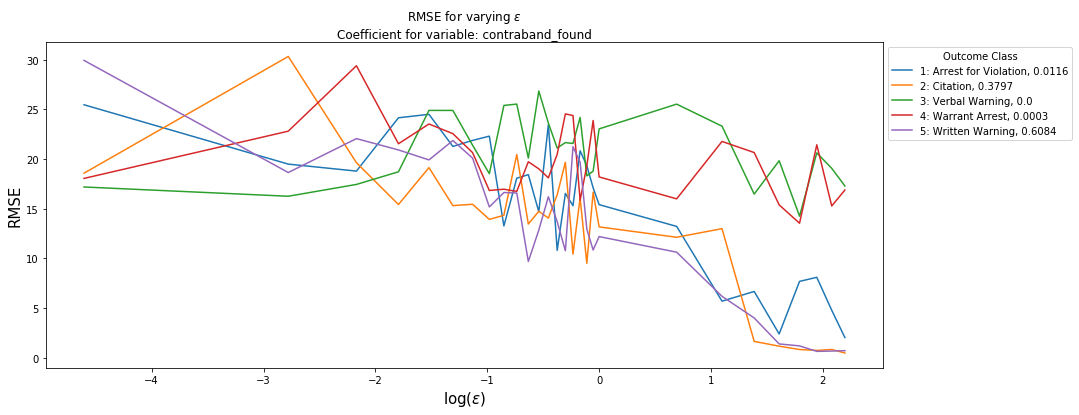

In [46]:
# choose coefficient to display
coef_num = str(4)
coef_names = ['Intercept'] + list(predictors.columns)

plt.figure(figsize = (15,6))
for k, v in enumerate(results):
    plt.plot(np.log(list_of_eps[:-1]),v[coef_num][:-1], 
             label = str(k+1) + ': ' + xwalk[str(k+1)]+ ', ' + str(np.round(class_size[k],4)))
plt.legend(title='Outcome Class', bbox_to_anchor=(1, 1))
plt.xlabel('$\log(\epsilon)$', fontsize = 15); plt.ylabel('RMSE', fontsize = 15) 
plt.title('RMSE for varying $\epsilon$' + '\nCoefficient for variable: '+ coef_names[int(coef_num)])
plt.show();

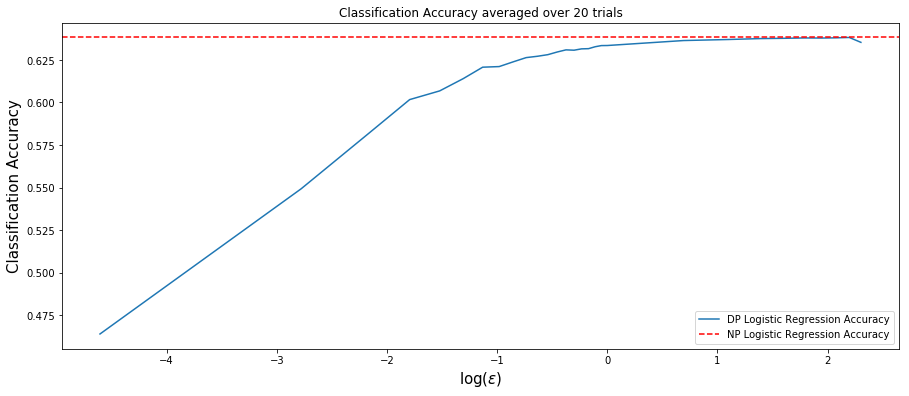

In [26]:
plt.figure(figsize = (15,6))
plt.plot(np.log(list_of_eps), mean_clf_acc, label = 'DP Logistic Regression Accuracy')
plt.axhline(baseline_np_acc, ls = '--', c = 'r', label = 'NP Logistic Regression Accuracy')
plt.xlabel(r'$\log(\epsilon)$', fontsize = 15); plt.ylabel('Classification Accuracy', fontsize = 15)
plt.title('Classification Accuracy averaged over ' + str(n_trials) + ' trials')
plt.legend()
plt.show();

---